<a href="https://colab.research.google.com/github/axiom9/WebScraping_and_NLP/blob/main/NLP_Tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/deep-learning-pipeline-for-natural-language-processing-nlp-c6f4074897bb

https://tfhub.dev/google/nnlm-en-dim50/2

https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/

https://medium.com/analytics-vidhya/introduction-to-nlp-with-disaster-tweets-3b672a75748c

https://www.analyticsvidhya.com/blog/2021/09/what-are-n-grams-and-how-to-implement-them-in-python/

Model architecture: https://www.kaggle.com/choureymanas/is-it-a-disaster

# Pre-reqs (Loading data)

In [1]:
import pandas as pd

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
def load_data():
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle competitions download -c nlp-getting-started

In [4]:
ls

kaggle.json  sample_data/  sample_submission.csv  test.csv  train.csv


In [5]:
load_data()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
df = pd.read_csv('/content/train.csv')

# **Pre-processing Data**

### Imports

In [7]:
! pip install langdetect
! pip install nltk==3.4
import nltk
# nltk.download('words')
nltk.download('punkt')
from nltk.corpus import words, stopwords
from nltk.stem import WordNetLemmatizer

from langdetect import detect

import re

import string
from string import digits

nltk.__version__

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'3.4'

In [8]:
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [9]:
df.isna().sum() / len(df)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

## Now we can begin pre-processing the sentences:

* Drop duplicates if any
* Drop any columns that might not be needed
* Drop missing values if any
* Remove punctuations
* Convert the words into lowercase
* Remove URLs, the word “twitter” and other acronyms
* Extract only tweets that are in English
* Tokenize (break the tweets into single words)
* Remove stopwords


In [10]:
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [11]:
# df2copy = df.text
# df2copy.apply(lambda sentences: [sentence for x in sentences if x in words.words()])

In [12]:

try:
    words = set(nltk.corpus.words.words())
except LookupError:
  nltk.download('words')
finally:
  words = set(nltk.corpus.words.words())

try:
  stop_words = set(stopwords.words('english'))
except LookupError:
  nltk.download('stopwords')
finally:
  stop_words = set(stopwords.words('english'))

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
def clean_data(df):
    """Function that cleans the data by dropping unwanted columns, duplicates, rows w/ missing tweets. Additionally, 
    it removes punctuation, expands contractions, removes stop-words, and performs lemmatization and tokenization 
    using NLTK Wordnet Lemmatizer and NLTK 'word_tokenize' module for tokenization."""

    # Dictionary to expand contractions (will be used later)
    contractions_dict = {"ain't": "are not","'s":" is","aren't": "are not", 
                     "shouldn't":"should not", "wouldn't":"would not", "couldn't":"could not",
                     "they're": "they are", "he'd":"he would", "I'm": "I am", "he's":"he is",
                     "isn't": "is not"}

    #Function to remove digits in text                    
    def remove_nums(text):
        """Removes any text (word) containing digits in it and properly concatenates
        the remaining sentence"""
        return " ".join(re.sub(r'\w*\d\w*', '', text).strip().split())

    #Function to remove URLs
    def remove_URL(text):
        """Remove URLs from a text string"""
        return re.sub(r"http\S+", "", text)

    # Function to expand contractions based on the contractions_dict
    def expand_contractions(text,contractions_dict=contractions_dict):
        def replace(match):
            return contractions_dict[match.group(0)]
        return contractions_re.sub(replace, text)

    # Function to remove ascii characters
    def remove_ascii(text):
        """Removes any ascii characters"""
        return text.encode("ascii", "ignore").decode()

    # Function to remove stop words
    def remove_stopwords(text):
        """Removes stopwords from a corpus"""
        return " ".join([word for word in str(text).split() if word not in stop_words])

    # Function to lemmatize words
    def lemmatize_words(text):
        """ Uses NLTK wordnet lemmatizer to lemmatize words """
        return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


    # def detect_languages(df):
    #     """Function that adds a new column in the dataframe passed that is the language the text is in"""
    #     # Check if the language is en, if it is do nothing, if it isn't then drop it
    #     for i in range(len(df.text)):
    #         if detect(df.text[i]) == 'en':
    #             df.drop(i, inplace=True)

    #Detect and drop rows that aren't in English - Temporarily excluding
    # detect_languages(df)

    # Make a copy of the df
    df = df.copy()

    # Drop columns that aren't needed
    cols_to_drop = ['id', 'keyword', 'location']
    df = df.drop(cols_to_drop, axis=1)
    # Note: We only need 'text' and 'target' columns for this deep learning task. Other columns can be effectively discarded

    # Regular expression for finding contractions
    contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

    # Expanding Contractions in the reviews
    df.text=df.text.apply(lambda x:expand_contractions(x))

    # Remove URLs
    df.text = df.text.apply(lambda x: remove_URL(x))

    # Remove ascii characters / text
    df.text = df.text.apply(lambda x:remove_ascii(x))

    # Removing punctutations
    df.text = df.text.apply(lambda x: x.translate(str.maketrans(' ',' ', string.punctuation)))

    # Removing numbers
    # df.text = df.text.apply(lambda x: x.translate(str.maketrans(' ',' ', digits)))
    df.text = df.text.apply(lambda x: remove_nums(x))

    # Lowercase
    df.text = df.text.apply(lambda x: x.lower())

    # Drop duplicates
    df.drop_duplicates(inplace=True) 

    # Drop any rows with missing tweets
    df.text.dropna(inplace=True)

    # Remove stop-words
    df.text = df.text.apply(lambda x: remove_stopwords(x))

    # Get the lemma of the words
    df.text = df.text.apply(lambda x: lemmatize_words(x))

    # Function to remove any extra unwanted spaces
    df.text = df.text.apply(lambda x: re.sub(' +', ' ', x))

    # Finally, let's perform tokenization using NLTK's module 'word_tokenize'
    df.text = df.text.apply(lambda x: nltk.word_tokenize(x))

    # Output the cleaned up dataframe
    return df

In [14]:
df2 = df.copy()
df2 = clean_data(df2)
df2

,text,target
0,"[deed, reason, earthquake, may, allah, forgive...",1
1,"[forest, fire, near, la, ronge, sask, canada]",1
2,"[resident, asked, ishelter, place, notified, o...",1
3,"[people, receive, wildfire, evacuation, order,...",1
4,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1
...,...,...
7601,"[breaking, la, refugio, oil, spill, may, costl...",1
7602,"[siren, went, wasnt, forney, tornado, warning]",1
7603,"[official, say, quarantine, place, alabama, ho...",1
7605,"[flip, side, walmart, bomb, everyone, evacuate...",1


# **Exploratory Data Analysis**

In [278]:
import seaborn as sns
import matplotlib.pyplot as plt

from nltk import ngrams
from collections import Counter, defaultdict
from itertools import chain

# from IPython.core.display import HTML, display

In [270]:
# display(HTML("""
# <style>
# #output-body {
#     display: flex;
#     align-items: center;
#     justify-content: center;
# }
# </style>
# """))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


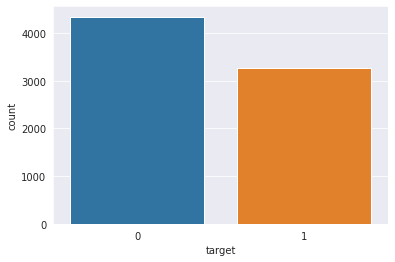

In [277]:
sns.countplot(df.target);


Fairly evenly distributed

In [250]:
def ngram_counts(n, df):
    def gen_ngrams(text, n):
        """ This function generates n-grams for all lists containing text 
        in a dataframe format """

        return [gram for gram in ngrams(text, n)]

    # Copy the df
    df = df.copy()

    # df3['grams'] = df3.text.apply(lambda x: gen_ngrams(x, 2))
    grams = df.text.apply(lambda x: gen_ngrams(x, n)).tolist()

    # Counter(df3.grams[62]).most_common(10)

    # bigrams = df3['grams'].tolist()
    grams = list(chain(*grams))

    gram_counts = Counter(grams)

    return  gram_counts.most_common(12)


In [251]:
# def gen_df_ngrams(df, n):
#     """ This function outputs 'n' number of of dataframes with the inputted filter
#     example: if you want no filter, then input 'df2', if you want the
#     disaster tweets, input 'df_sad' """

# Generate various n-grams for the entire dataset (all tweets)
whole_df_1 = pd.DataFrame(ngram_counts(1, df2), columns=['grams', 'counts']) #<-- whole dataset, unigrams
whole_df_2 = pd.DataFrame(ngram_counts(2, df2), columns=['grams', 'counts']) #<-- whole dataset, bigrams
whole_df_3 = pd.DataFrame(ngram_counts(3, df2), columns=['grams', 'counts']) #<-- whole dataset, trigrams

# Filter the dataframe so it's only either a '1' disaster or a '0'
df_happy = df2[df2.target == 0]
df_sad = df2[df2.target == 1]

# Generate various n-grams for the two filters
dis_1 = pd.DataFrame(ngram_counts(1, df_sad), columns=['grams', 'counts']) #<-- disaster tweets, unigrams
dis_2 = pd.DataFrame(ngram_counts(2, df_sad), columns=['grams', 'counts']) #<-- disaster tweets, bigrams
dis_3 = pd.DataFrame(ngram_counts(3, df_sad), columns=['grams', 'counts']) #<-- disaster tweets, trigrams

ndis_1 = pd.DataFrame(ngram_counts(1, df_happy), columns=['grams', 'counts']) #<-- non-disaster tweets, unigrams
ndis_2 = pd.DataFrame(ngram_counts(2, df_happy), columns=['grams', 'counts']) #<-- non-disaster tweets, bigrams
ndis_3 = pd.DataFrame(ngram_counts(3, df_happy), columns=['grams', 'counts']) #<-- non-disaster tweets, trigrams

In [252]:
sns.set_style('darkgrid')
def gen_plot(df):
    plt.figure(figsize=(12,7));
    sns.barplot(x=df.counts, y=df.grams, data=df);
    plt.ylabel('Grams', fontsize=12.0, fontweight='bold')
    plt.xlabel('Counts', fontsize=12.0, fontweight='bold')

def gplots_whole_df()
    
# fig, axs = plt.subplots(ncols=3, figsize=(10,10))

# sns.barplot(x=dis_1.counts, y=dis_1.grams, ax=axs[0])
# # sns.barplot(x=dis_2.counts, y=dis_2.grams, ax=axs[1])
# # sns.barplot(x=dis_3.counts, y=dis_3.grams, ax=axs[2])

## Plots for n-grams

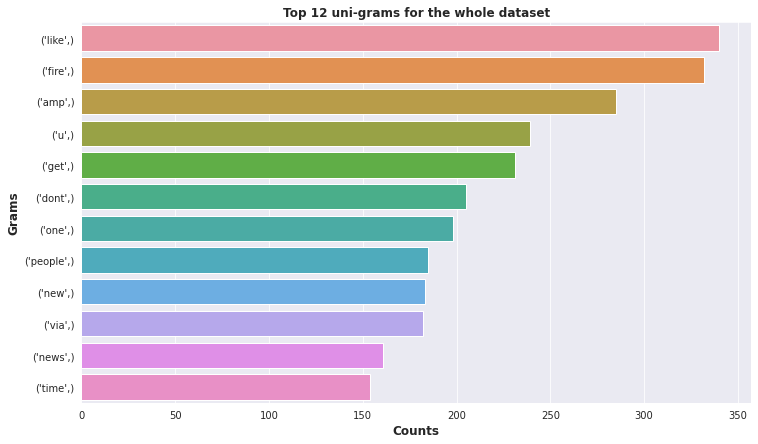

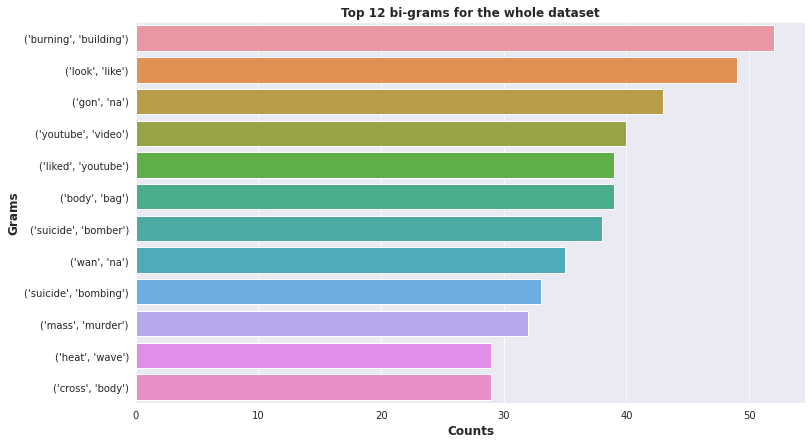

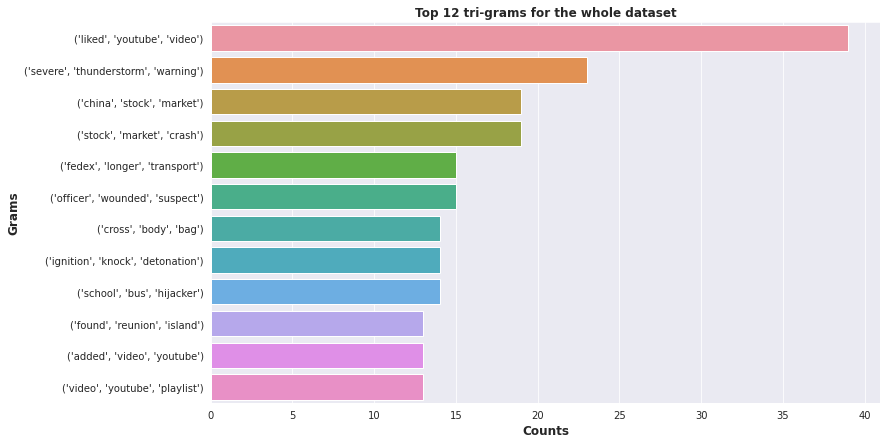

In [281]:
gen_plot(whole_df_1)
plt.title('Top 12 uni-grams for the whole dataset',fontsize=12.0, fontweight='bold');
gen_plot(whole_df_2)
plt.title('Top 12 bi-grams for the whole dataset', fontsize=12.0, fontweight='bold');
gen_plot(whole_df_3)
plt.title('Top 12 tri-grams for the whole dataset', fontsize=12.0, fontweight='bold');

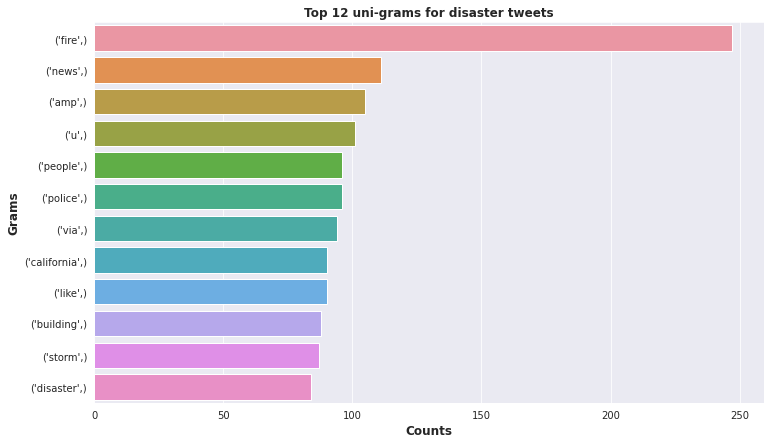

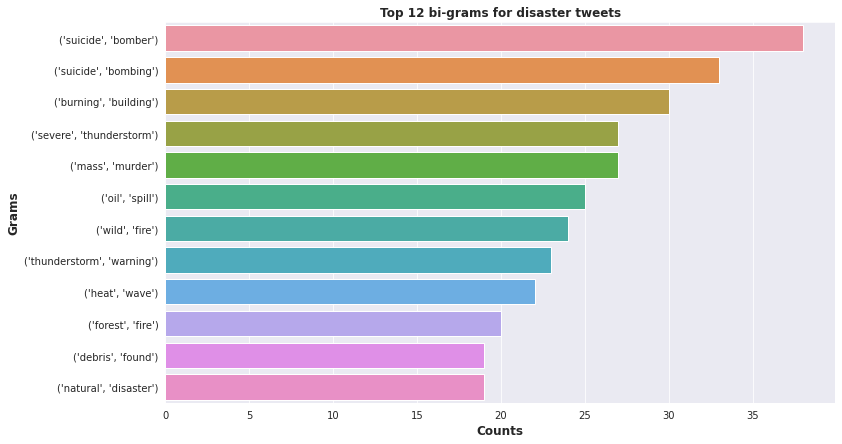

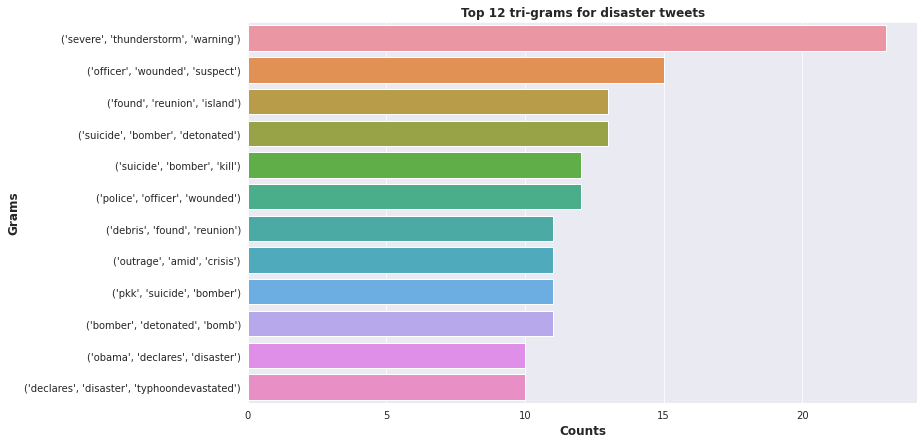

In [280]:
gen_plot(dis_1)
plt.title('Top 12 uni-grams for disaster tweets', fontsize=12.0, fontweight='bold');
gen_plot(dis_2)
plt.title('Top 12 bi-grams for disaster tweets', fontsize=12.0, fontweight='bold');
gen_plot(dis_3)
plt.title('Top 12 tri-grams for disaster tweets', fontsize=12.0, fontweight='bold');

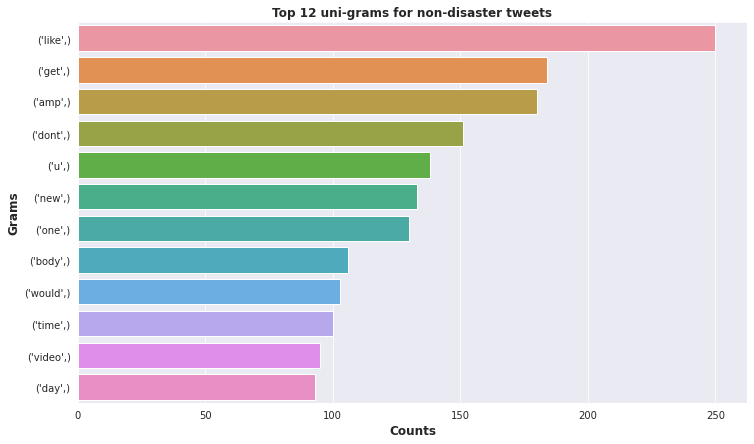

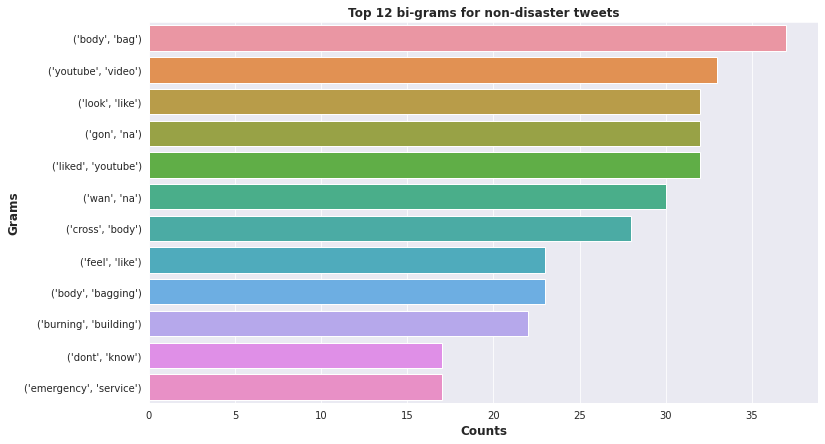

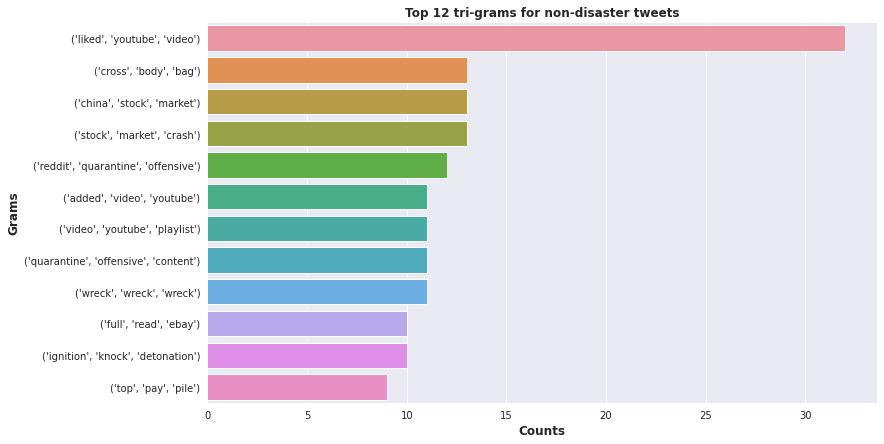

In [282]:
gen_plot(ndis_1)
plt.title('Top 12 uni-grams for non-disaster tweets', fontsize=12.0, fontweight='bold');
gen_plot(ndis_2)
plt.title('Top 12 bi-grams for non-disaster tweets', fontsize=12.0, fontweight='bold');
gen_plot(ndis_3)
plt.title('Top 12 tri-grams for non-disaster tweets', fontsize=12.0, fontweight='bold');

In [283]:
# To-do: Visualize 'entry' lengths for the three divisions (entire dataset, disaster tweets, and non-disaster tweets) then OHE and vectorize and move into model development